# SANDAG Populationsim QC

In [1]:
import pandas as pd
import numpy as np
import pyodbc
import glob
import copy
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

### Download Populationsim data

In [2]:
synthetic_households = pd.read_csv('C:/Users/cra/San Diego Association of Governments/SANDAG QA QC - Documents/Projects/2022/2022-72 SANDPOPSIM Output QC/Population Sim Outputs/synthetic_households.csv')
synthetic_persons = pd.read_csv('C:/Users/cra/San Diego Association of Governments/SANDAG QA QC - Documents/Projects/2022/2022-72 SANDPOPSIM Output QC/Population Sim Outputs/synthetic_persons.csv')

In [9]:
synthetic_households.head()

,household_id,tract,mgra,NP,HHADJINC,ADJINC,HHT,WIF,HUPAC,VEH,numWorkers,GQ_type
0,1,18100.0,245,3,121500.0,1010145,3.0,2.0,4.0,3.0,1.0,NaN
1,2,18100.0,245,3,75400.0,1010145,1.0,2.0,1.0,2.0,2.0,NaN
2,3,18100.0,245,3,45800.0,1010145,3.0,1.0,4.0,1.0,1.0,NaN
3,4,18100.0,245,3,70000.0,1010145,1.0,2.0,1.0,2.0,2.0,NaN
4,5,18100.0,245,1,35700.0,1010145,6.0,NaN,4.0,1.0,1.0,NaN


In [11]:
synthetic_persons[synthetic_persons['household_id'] == 2]

,tract,mgra,household_id,SPORDER,AGEP,SEX,ESR,COW,WKHP,SCHG,RAC1P,HISP,MIL,isWorker
3,18100.0,245,2,1,25,2,4.0,5.0,50.0,15.0,6,2,1.0,1
4,18100.0,245,2,2,24,1,1.0,6.0,20.0,15.0,1,1,2.0,1
5,18100.0,245,2,3,4,2,NaN,NaN,NaN,1.0,6,2,NaN,0


In [8]:
df = synthetic_households[(synthetic_households['HHT'] == 4) | (synthetic_households['HHT'] == 6)]
df[df['NP'] > 1]

,household_id,tract,mgra,NP,HHADJINC,ADJINC,HHT,WIF,HUPAC,VEH,numWorkers,GQ_type


In [3]:
synthetic_persons[synthetic_persons['isWorker']==1].shape[0]

1556474

# ACS Population Comparison

In [4]:
# Download Data
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=ddamwsql16.sandag.org;'
                      'Database=census;'
                      'Trusted_Connection=yes;')

query = '''SELECT summary_level, geo_name, tract, estimate FROM census.acs.vw_summary_file WHERE subject_table = 'B01003' AND yr = 2019 AND county = 073 AND summary_level=140'''

acs_data = pd.read_sql_query(query,conn)

In [5]:
# Group the ACS Data by tract 
acs_grouped_data = acs_data[['tract', 'estimate']].groupby('tract').sum().reset_index()
acs_grouped_data['tract'] = acs_grouped_data['tract'].astype(int)
#acs_grouped_data.head(3)

In [6]:
# Group the synthetic households by tract  
sh_grouped_bytract = synthetic_households[['tract', 'NP']].groupby('tract').sum().reset_index()
#sh_grouped_bytract.head(3)

In [7]:
# Find the difference in Population
acs_sh_tract_comp = sh_grouped_bytract.merge(acs_grouped_data, how="left", on="tract")
acs_sh_tract_comp.columns = ['tract', 'Popsim Pop', 'ACS Pop']
acs_sh_tract_comp["Diff"] = acs_sh_tract_comp['Popsim Pop'] - acs_sh_tract_comp['ACS Pop']
acs_sh_tract_comp = acs_sh_tract_comp.sort_values('Diff')

#acs_sh_tract_comp.to_excel('C:/Users/cra/Desktop/summary_level_140_acs_popsim_diff.xlsx')

PermissionError: [Errno 13] Permission denied: 'C:/Users/cra/Desktop/summary_level_140_acs_popsim_diff.xlsx'

In [ ]:
print(f"ACS data has a total population of: {sum(acs_data['estimate'])}")
print(f"Popsim data has a total population of: {sum(sh_grouped_bytract['NP'])}")
print(f"The difference is: {sum(acs_data['estimate']) - sum(sh_grouped_bytract['NP'])} which is a {round((sum(acs_data['estimate']) - sum(sh_grouped_bytract['NP']))/sum(sh_grouped_bytract['NP']) * 100, 2)} percent difference")

ACS data has a total population of: 3316073.0
Popsim data has a total population of: 3247180
The difference is: 68893.0 which is a 2.12 percent difference


In [ ]:
acs_sh_tract_comp

,tract,Popsim Pop,ACS Pop,Diff
501,18700.0,27174,38754.0,-11580.0
619,21900.0,1772,7107.0,-5335.0
302,13310.0,27635,31118.0,-3483.0
612,21302.0,4190,7616.0,-3426.0
47,2904.0,6969,10078.0,-3109.0
...,...,...,...,...
606,21000.0,6146,2706.0,3440.0
191,8511.0,8542,4989.0,3553.0
561,20029.0,10637,5808.0,4829.0
616,21500.0,16410,11078.0,5332.0


# ACS Household Comparison

In [20]:
# Download Data
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=ddamwsql16.sandag.org;'
                      'Database=census;'
                      'Trusted_Connection=yes;')

query = """SELECT tract, estimate FROM census.acs.vw_summary_file WHERE subject_table = 'B11016' AND yr = 2019 AND county = 073 AND summary_level=140 AND line_desc = 'Total:'"""

acs_hs_data = pd.read_sql_query(query,conn)
acs_hs_data['tract'] = acs_hs_data['tract'].astype(int)

In [21]:
acs_hs_data

,tract,estimate
0,17053,1061.0
1,8701,1233.0
2,201,1080.0
3,3303,1254.0
4,17035,1189.0
...,...,...
623,8352,1113.0
624,19107,738.0
625,16902,840.0
626,13907,1399.0


In [18]:
acs_hs_data['tract'] = acs_hs_data['tract'].astype(int)

In [12]:
synthetic_households

,household_id,tract,mgra,NP,HHADJINC,ADJINC,HHT,WIF,HUPAC,VEH,numWorkers,GQ_type
0,1,18100.0,245,3,121500.0,1010145,3.0,2.0,4.0,3.0,1.0,NaN
1,2,18100.0,245,3,75400.0,1010145,1.0,2.0,1.0,2.0,2.0,NaN
2,3,18100.0,245,3,45800.0,1010145,3.0,1.0,4.0,1.0,1.0,NaN
3,4,18100.0,245,3,70000.0,1010145,1.0,2.0,1.0,2.0,2.0,NaN
4,5,18100.0,245,1,35700.0,1010145,6.0,NaN,4.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1262831,1262832,NaN,24280,1,1600.0,1010145,NaN,NaN,NaN,NaN,0.0,3.0
1262832,1262833,NaN,24280,1,1600.0,1010145,NaN,NaN,NaN,NaN,0.0,3.0
1262833,1262834,NaN,24280,1,13000.0,1010145,NaN,NaN,NaN,NaN,0.0,3.0
1262834,1262835,NaN,24280,1,0.0,1010145,NaN,NaN,NaN,NaN,0.0,3.0


In [17]:
sh_H_grouped_bytract = synthetic_households[['tract', 'NP']].groupby('tract').count().reset_index()

sh_H_grouped_bytract

,tract,NP
0,100.0,1312
1,201.0,1067
2,202.0,2347
3,300.0,3044
4,400.0,2326
...,...,...
617,21600.0,930
618,21800.0,866
619,21900.0,594
620,22000.0,1205


In [25]:
acs_popsim_households_comp = sh_H_grouped_bytract.merge(acs_hs_data, how='left', on='tract')

acs_popsim_households_comp.columns = ['tract', 'popsim_hh', 'acs_hh']

acs_popsim_households_comp['Diff'] = acs_popsim_households_comp['popsim_hh'] - acs_popsim_households_comp['acs_hh']

acs_popsim_households_comp = acs_popsim_households_comp.sort_values('Diff', ascending=False)

acs_popsim_households_comp

,tract,popsim_hh,acs_hh,Diff
98,5100.0,5989,3892.0,2097.0
616,21500.0,4364,3475.0,889.0
121,7600.0,2904,2049.0,855.0
100,5300.0,3597,2752.0,845.0
191,8511.0,2926,2149.0,777.0
...,...,...,...,...
261,10900.0,724,923.0,-199.0
263,11100.0,1637,1851.0,-214.0
45,2902.0,2301,2548.0,-247.0
545,20013.0,4719,4970.0,-251.0


In [26]:
#acs_popsim_households_comp.to_excel('C:/Users/cra/Desktop/popsim_acs_household_difference.xlsx')

# LEHD Comparison 

## RAC

In [27]:
# Download Data
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=ddamwsql16.sandag.org;'
                      'Database=dpoe_stage;'
                      'Trusted_Connection=yes;')

query = """SELECT SUM(C000)
FROM [dpoe_stage].[lehd_lodes].[rac_7_5_20211018]
WHERE yr = 2019 AND type = 'JT00' AND segment = 'S000'"""

lehd_RAC_jobs_sum = pd.read_sql_query(query,conn)

In [28]:
lehd_RAC_total = lehd_RAC_jobs_sum[''][0]
lehd_RAC_total

1467579

In [29]:
# From popsim
popsim_isworker = synthetic_persons[synthetic_persons['isWorker']==1].shape[0]
popsim_isworker

1556474

In [30]:
diff_worker_popsim_lehd = popsim_isworker - lehd_RAC_total
diff_worker_popsim_lehd

88895

In [31]:
# Download Data
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=ddamwsql16.sandag.org;'
                      'Database=dpoe_stage;'
                      'Trusted_Connection=yes;')

query = """SELECT SUBSTRING(h_geoid, 6, 6) AS tract, SUM(C000) AS 'sum of employment'
FROM [dpoe_stage].[lehd_lodes].[rac_7_5_20211018]
WHERE yr = 2019 AND type = 'JT00' AND segment = 'S000'
GROUP BY SUBSTRING(h_geoid, 6, 6);"""

lehd_RAC_jobs_tract_sum = pd.read_sql_query(query,conn)

In [33]:
lehd_RAC_jobs_tract_sum['tract'] = lehd_RAC_jobs_tract_sum['tract'].astype(int)
lehd_RAC_jobs_tract_sum

,tract,sum of employment
0,20013,5641
1,20807,1406
2,21206,1497
3,2902,2874
4,11100,1391
...,...,...
622,21600,693
623,14300,1981
624,3208,3456
625,18610,3270


In [54]:
# popsim adjustments
popsim_isworker_output = synthetic_persons[synthetic_persons['isWorker']==1]
popsim_isworker_output['count'] = None
popsim_isworker_output

,tract,mgra,household_id,SPORDER,AGEP,SEX,ESR,COW,WKHP,SCHG,RAC1P,HISP,MIL,isWorker,count
0,18100.0,245,1,1,52,2,1.0,1.0,40.0,NaN,1,2,4.0,1,None
3,18100.0,245,2,1,25,2,4.0,5.0,50.0,15.0,6,2,1.0,1,None
4,18100.0,245,2,2,24,1,1.0,6.0,20.0,15.0,1,1,2.0,1,None
6,18100.0,245,3,1,64,2,1.0,4.0,60.0,NaN,1,1,4.0,1,None
9,18100.0,245,4,1,41,2,1.0,6.0,40.0,NaN,1,3,4.0,1,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356832,NaN,24280,1262700,1,21,2,1.0,1.0,8.0,NaN,2,1,4.0,1,None
3356853,NaN,24280,1262721,1,81,1,1.0,2.0,10.0,NaN,1,1,4.0,1,None
3356857,NaN,24280,1262725,1,19,1,1.0,5.0,60.0,NaN,1,2,2.0,1,None
3356920,NaN,24280,1262788,1,81,1,1.0,2.0,10.0,NaN,1,1,4.0,1,None


In [47]:
popsim_isworker_output = popsim_isworker_output[['tract', 'isWorker']].groupby('tract').count().reset_index()
popsim_isworker_output.columns = ['tract', 'count']

popsim_isworker_output


,tract,count
0,100.0,1593
1,201.0,927
2,202.0,2799
3,300.0,3331
4,400.0,2761
...,...,...
617,21600.0,870
618,21800.0,978
619,21900.0,777
620,22000.0,1937


In [52]:
lehd_households_tract_comp = popsim_isworker_output.merge(lehd_RAC_jobs_tract_sum, how='left', on='tract')

lehd_households_tract_comp.columns = ['tract', 'popsim_worker', 'lehd_worker']

lehd_households_tract_comp['Diff'] = lehd_households_tract_comp['popsim_worker'] - lehd_households_tract_comp['lehd_worker']

lehd_households_tract_comp.sort_values('Diff', ascending=False)

lehd_households_tract_comp

,tract,popsim_worker,lehd_worker,Diff
0,100.0,1593,1249,344
1,201.0,927,933,-6
2,202.0,2799,2323,476
3,300.0,3331,2621,710
4,400.0,2761,2250,511
...,...,...,...,...
617,21600.0,870,693,177
618,21800.0,978,784,194
619,21900.0,777,1951,-1174
620,22000.0,1937,2201,-264


In [53]:
#lehd_households_tract_comp.to_excel('C:/Users/cra/Desktop/popsim_lehd_worker_difference.xlsx')

# Requested Output (From Purva)

In [ ]:
df1 = synthetic_households[['household_id','mgra', 'HHADJINC','GQ_type', 'NP']][synthetic_households[['household_id','mgra', 'HHADJINC','GQ_type', 'NP']]['HHADJINC'] == 0]

df2 = df1[(df1['GQ_type'].isna())]

df2

df3 = synthetic_persons[synthetic_persons['household_id'].isin(df2['household_id'])]

#### Download Forecast Data

In [ ]:
forecast_data_mgra = pd.read_csv('J:/DataScience/DataQuality/QAQC/forecast_automation/mgra_series_15_2019_CSV_outputs/mgra_2019_CSV_Data_ind_QA.csv')
forecast_data_jurisdiction = pd.read_csv('J:/DataScience/DataQuality/QAQC/forecast_automation/mgra_series_15_2019_CSV_outputs/jurisdiction_2019_CSV_Data_ind_QA.csv')
forecast_data_region = pd.read_csv('J:/DataScience/DataQuality/QAQC/forecast_automation/mgra_series_15_2019_CSV_outputs/region_2019_CSV_Data_ind_QA.csv')

# Which MGRAs are not present

In [ ]:
# Download Data
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=SQL2014B8.sandag.org;'
                      'Database=GeoDepot;'
                      'Trusted_Connection=yes;')

query = '''SELECT
      [MGRA]
  FROM [GeoDepot].[gis].[MGRA15]'''

crosswalk = pd.read_sql_query(query,conn)

In [ ]:
#pd.DataFrame({'mgras_not_in_popsim':list(set(crosswalk['MGRA']) - set(synthetic_persons['mgra']))})#.to_excel('C:/Users/cra/Desktop/mgras_not_in_popsim.xlsx')

# Non Group Quarters Population Sum Comparison 
- 'hhp' = total household population (exclude gq pop) (https://github.com/SANDAG/ABM/wiki/input-files)

In [ ]:
# From populationsim
hs_small_df = synthetic_households[['mgra', 'NP', 'GQ_type']]
non_gq = hs_small_df[(hs_small_df['GQ_type'].isna())]
non_gq_pop_sum = non_gq[['mgra', 'NP']].groupby('mgra').sum()

In [ ]:
non_gq_pop_comparison = non_gq_pop_sum.reset_index().merge(forecast_data_mgra[['mgra', 'hhp']], how='left', on='mgra')
non_gq_pop_comparison.columns = ['mgra', 'Populationsim Pop', 'Forecast Pop']
non_gq_pop_comparison.set_index('mgra')
non_gq_pop_comparison['Diff'] = non_gq_pop_comparison['Populationsim Pop'] - non_gq_pop_comparison['Forecast Pop']

non_gq_pop_comparison

,mgra,Populationsim Pop,Forecast Pop,Diff
0,1,500,542,-42
1,2,73,83,-10
2,3,553,559,-6
3,4,2,3,-1
4,5,109,105,4
...,...,...,...,...
18606,24313,169,56,113
18607,24314,72,66,6
18608,24316,504,567,-63
18609,24317,9,18,-9


In [ ]:
non_gq_pop_comparison.sort_values('Diff', ascending=False)

,mgra,Populationsim Pop,Forecast Pop,Diff
6170,7507,4228,3623,605
15445,19747,3194,2742,452
4904,5878,9910,9532,378
2160,2428,3395,3028,367
14518,18520,1807,1452,355
...,...,...,...,...
15291,19499,1465,1610,-145
2456,2768,673,821,-148
5745,6963,1952,2105,-153
10388,13437,1852,2013,-161


In [ ]:
non_gq_pop_comparison#.to_csv(r'C:\Users\cra\San Diego Association of Governments\SANDAG QA QC - Documents\Projects\2022\2022-72 SANDPOPSIM Output QC\QA Data\non_gq_pop_comparison.csv')

,mgra,Populationsim Pop,Forecast Pop,Diff
0,1,500,542,-42
1,2,73,83,-10
2,3,553,559,-6
3,4,2,3,-1
4,5,109,105,4
...,...,...,...,...
18606,24313,169,56,113
18607,24314,72,66,6
18608,24316,504,567,-63
18609,24317,9,18,-9


# Group Quarter Population Sum Comparison 

In [ ]:
# Grabbing Popsim info
gq_popsim = hs_small_df[~(hs_small_df['GQ_type'].isna())]
gq_pop_sum = gq_popsim[['mgra', 'NP']].groupby('mgra').sum()

In [ ]:
# Grabbing Forecast Info
gq_pop_forecast = forecast_data_mgra[['mgra', 'pop', 'hhp']]
gq_pop_forecast['gq_pop'] = gq_pop_forecast['pop'] - gq_pop_forecast['hhp']

In [ ]:
gq_pop_comparison = gq_pop_sum.reset_index().merge(gq_pop_forecast[['mgra', 'gq_pop']], how='left', on='mgra')
gq_pop_comparison.columns = ['mgra', 'Populationsim Pop', 'Forecast Pop']
gq_pop_comparison.set_index('mgra')
gq_pop_comparison['Diff'] = gq_pop_comparison['Populationsim Pop'] - gq_pop_comparison['Forecast Pop']


gq_pop_comparison#.to_csv(r'C:\Users\cra\San Diego Association of Governments\SANDAG QA QC - Documents\Projects\2022\2022-72 SANDPOPSIM Output QC\QA Data\gq_pop_comparison.csv')

,mgra,Populationsim Pop,Forecast Pop,Diff
0,25,2,2,0
1,28,1,1,0
2,50,1,1,0
3,53,4,4,0
4,55,1,1,0
...,...,...,...,...
1412,24024,641,641,0
1413,24079,2,2,0
1414,24084,16,16,0
1415,24254,3,3,0


# Non Group Quarter Household NUmber Comparison  

In [ ]:
# From popsim
hs_non_gq_sum = pd.DataFrame(non_gq['mgra'].value_counts())
hs_non_gq_sum = hs_non_gq_sum.reset_index()
hs_non_gq_sum.columns = ['mgra', 'hh_popsim']

In [ ]:
# From forecast 
forecast_non_gq_hh_sum = forecast_data_mgra[['mgra','hh']]
forecast_non_gq_hh_sum.columns = ['mgra', 'hh_forecast']

In [ ]:
non_gq_hh_comp = hs_non_gq_sum.merge(forecast_non_gq_hh_sum, how='left', on='mgra')
non_gq_hh_comp['Diff'] = non_gq_hh_comp['hh_popsim'] - non_gq_hh_comp['hh_forecast']
non_gq_hh_comp#.to_csv(r'C:\Users\cra\San Diego Association of Governments\SANDAG QA QC - Documents\Projects\2022\2022-72 SANDPOPSIM Output QC\QA Data\non_gq_HH_comparison.xlsx')

non_gq_hh_comp[non_gq_hh_comp['Diff'] != 0].sort_values('Diff', ascending=True)

,mgra,hh_popsim,hh_forecast,Diff
3835,19531,93,98,-5
9262,16707,41,46,-5
5090,19473,77,81,-4
659,5430,218,222,-4
13191,15691,20,24,-4
...,...,...,...,...
469,16071,250,246,4
384,12873,272,268,4
1381,19514,159,154,5
6488,19470,62,57,5


# Group Quarter Household Number Comparison

In [ ]:
# Forecast
gq_hh_forecast = forecast_data_mgra[['mgra', 'gq_civ', 'gq_mil']]
gq_hh_forecast['gq_hh_total_forecast'] = gq_hh_forecast['gq_civ'] + gq_hh_forecast['gq_mil']
gq_hh_forecast = gq_hh_forecast[['mgra', 'gq_hh_total_forecast']]

In [ ]:
# Populationsim 
gq_household_popsim = hs_small_df[~(hs_small_df['GQ_type'].isna())]
hs_gq_sum_pop_sim = pd.DataFrame(gq_household_popsim['mgra'].value_counts())
hs_gq_sum_pop_sim = hs_gq_sum_pop_sim.reset_index()
hs_gq_sum_pop_sim.columns = ['mgra', 'hh_gq_popsim']

In [ ]:
hh_gq_sum_comparison = hs_gq_sum_pop_sim.merge(gq_hh_forecast, how='left', on='mgra')
hh_gq_sum_comparison['Diff'] = hh_gq_sum_comparison['hh_gq_popsim'] - hh_gq_sum_comparison['gq_hh_total_forecast']

hh_gq_sum_comparison#.to_csv(r'C:\Users\cra\San Diego Association of Governments\SANDAG QA QC - Documents\Projects\2022\2022-72 SANDPOPSIM Output QC\QA Data\gq_HH_comparison.xlsx')

hh_gq_sum_comparison[hh_gq_sum_comparison['Diff'] != 0]

,mgra,hh_gq_popsim,gq_hh_total_forecast,Diff


# Purva Median Income Request 

In [ ]:
new_df = synthetic_households[['mgra', 'HHADJINC']].groupby('mgra').median()

In [ ]:
synthetic_households[['mgra', 'HHADJINC']][synthetic_households[['mgra', 'HHADJINC']]['mgra'] == 9179]

,mgra,HHADJINC
1138568,9179,86700.0
1240392,9179,0.0
1240393,9179,950.0
1240394,9179,3000.0
1240395,9179,0.0
1240396,9179,0.0
1240397,9179,32000.0
1240398,9179,9600.0
1240399,9179,0.0
1240400,9179,0.0


In [ ]:
new_df = synthetic_households[['mgra', 'HHADJINC']].groupby('mgra').median()
new_df.columns = ['Median Adj Income']

#new_df.to_excel('C:/Users/cra/Desktop/median_income.xlsx')

In [ ]:
# Checking to see if the creation of that median file dropped any MGRAs
synthetic_households['mgra'].nunique()
synthetic_households[['mgra', 'HHADJINC']].groupby('mgra').median().reset_index()['mgra'].nunique()

18902

### Download Crosswalk Data

In [ ]:
# Download Data
conn = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                      'Server=SQL2014B8.sandag.org;'
                      'Database=GeoDepot;'
                      'Trusted_Connection=yes;')

query = '''SELECT
      [MGRA]
	  ,cpa_data.NAME AS CPA
	  ,jur_data.Name AS Jurisdiction
      ,[LUZ]
  FROM [GeoDepot].[gis].[MGRA15] as mgra_base
  LEFT JOIN [GeoDepot].[gis].[CITIES] AS jur_data
  ON mgra_base.City = jur_data.City
  LEFT JOIN [GeoDepot].[gis].[CITYCPA] AS cpa_data
  ON mgra_base.CPA = cpa_data.CPA'''

crosswalk = pd.read_sql_query(query,conn)

In [ ]:
# Appending to synthetic data
synthetic_households= synthetic_households.merge(crosswalk, left_on='mgra', right_on='MGRA', how='left')
synthetic_persons = synthetic_persons.merge(crosswalk, left_on='mgra', right_on='MGRA', how='left')

In [ ]:
synthetic_persons['Region'] = 'San Diego'
synthetic_households['Region'] = 'San Diego'

In [ ]:
synthetic_persons.head()

,tract,mgra,household_id,SPORDER,AGEP,SEX,ESR,COW,WKHP,SCHG,RAC1P,HISP,MIL,isWorker,MGRA,CPA,Jurisdiction,LUZ,Region
0,18100.0,245,1,1,52,2,1.0,1.0,40.0,NaN,1,2,4.0,1,245,None,Oceanside,161,San Diego
1,18100.0,245,1,2,39,1,3.0,1.0,40.0,NaN,1,2,4.0,0,245,None,Oceanside,161,San Diego
2,18100.0,245,1,3,79,2,6.0,NaN,NaN,NaN,1,2,4.0,0,245,None,Oceanside,161,San Diego
3,18100.0,245,2,1,25,2,4.0,5.0,50.0,15.0,6,2,1.0,1,245,None,Oceanside,161,San Diego
4,18100.0,245,2,2,24,1,1.0,6.0,20.0,15.0,1,1,2.0,1,245,None,Oceanside,161,San Diego


# Calculating the range
Request from Purva. 

In [ ]:
list_of_mgras = list(set(synthetic_households['MGRA']))

In [ ]:
hh_inc_filter = synthetic_households[['MGRA', 'HHADJINC']]

In [ ]:
final_df = dict()
for mgra in list_of_mgras:
    # Find the Max
    max_value = max(hh_inc_filter[hh_inc_filter['MGRA'] == mgra]['HHADJINC'])

    # find the min 
    min_value = min(hh_inc_filter[hh_inc_filter['MGRA'] == mgra]['HHADJINC'])

    # Range
    range_value = max_value - min_value

    # Add to dataframe
    final_df[mgra] = [max_value, min_value, range_value]

In [ ]:
final_output = pd.DataFrame(final_df).T
final_output.columns = ['Max', 'Min', 'Range']
final_output.index.name = 'mgra'
final_output

,Max,Min,Range
mgra,,,
1,609400.0,30.0,609370.0
2,236000.0,0.0,236000.0
3,731200.0,590.0,730610.0
4,118900.0,21600.0,97300.0
5,360000.0,11600.0,348400.0
...,...,...,...
24313,160900.0,39000.0,121900.0
24314,937000.0,11600.0,925400.0
24316,926000.0,0.0,926000.0


# Geography Rollup

In [ ]:
# Synthetic Population (SP) -- with GQ
sh_mgra = pd.DataFrame(synthetic_households['mgra'].value_counts()).rename(columns={'mgra':'Total'})
sh_mgra.index.name = 'mgra'

sh_tract = pd.DataFrame(synthetic_households['tract'].value_counts()).rename(columns={'tract':'Total'})
sh_tract.index.name = 'tract'

sh_CPA = pd.DataFrame(synthetic_households['CPA'].value_counts()).rename(columns={'CPA':'Total'})
sh_CPA.index.name = 'CPA'

sh_jurisdiction = pd.DataFrame(synthetic_households['Jurisdiction'].value_counts()).rename(columns={'Jurisdiction':'Total'})
sh_jurisdiction.index.name = 'Jurisdiction'

sh_LUZ = pd.DataFrame(synthetic_households['LUZ'].value_counts()).rename(columns={'LUZ':'Total'})
sh_LUZ.index.name = 'LUZ'

sh_Region = pd.DataFrame(synthetic_households['Region'].value_counts()).rename(columns={'Region':'Total'})
sh_Region.index.name = 'Region'

In [ ]:
# Synthetic Population (SP) -- with GQ
sh_mgra = pd.DataFrame(synthetic_households['mgra'].value_counts()).rename(columns={'mgra':'Total'})
sh_mgra.index.name = 'mgra'

sh_tract = pd.DataFrame(synthetic_households['tract'].value_counts()).rename(columns={'tract':'Total'})
sh_tract.index.name = 'tract'

sh_CPA = pd.DataFrame(synthetic_households['CPA'].value_counts()).rename(columns={'CPA':'Total'})
sh_CPA.index.name = 'CPA'

sh_jurisdiction = pd.DataFrame(synthetic_households['Jurisdiction'].value_counts()).rename(columns={'Jurisdiction':'Total'})
sh_jurisdiction.index.name = 'Jurisdiction'

sh_LUZ = pd.DataFrame(synthetic_households['LUZ'].value_counts()).rename(columns={'LUZ':'Total'})
sh_LUZ.index.name = 'LUZ'

sh_Region = pd.DataFrame(synthetic_households['Region'].value_counts()).rename(columns={'Region':'Total'})
sh_Region.index.name = 'Region'

In [ ]:
# Synthetic Persons (SP) -- without GQ
sp_mgra = pd.DataFrame(synthetic_persons['mgra'].value_counts()).rename(columns={'mgra':'Total'})
sp_mgra.index.name = 'mgra'

sp_tract = pd.DataFrame(synthetic_persons['tract'].value_counts()).rename(columns={'tract':'Total'})
sp_tract.index.name = 'tract'

sp_CPA = pd.DataFrame(synthetic_persons['CPA'].value_counts()).rename(columns={'CPA':'Total'})
sp_CPA.index.name = 'CPA'

sp_jurisdiction = pd.DataFrame(synthetic_persons['Jurisdiction'].value_counts()).rename(columns={'Jurisdiction':'Total'})
sp_jurisdiction.index.name = 'Jurisdiction'

sp_LUZ = pd.DataFrame(synthetic_persons['LUZ'].value_counts()).rename(columns={'LUZ':'Total'})
sp_LUZ.index.name = 'LUZ'

sp_Region = pd.DataFrame(synthetic_persons['Region'].value_counts()).rename(columns={'Region':'Total'})
sp_Region.index.name = 'Region'

# Internal Consistency Checks

In [ ]:
# Synthetic Persons
print(f"MGRA total - {sp_mgra['Total'].sum()}")
print(f"Tract total - {sp_tract['Total'].sum()}")
print(f"CPA total - {sp_CPA['Total'].sum()}")
print(f"Jurisdiction Total - {sp_jurisdiction['Total'].sum()}")
print(f"LUZ total - {sp_LUZ['Total'].sum()}")
print(f"Region total - {sp_Region['Total'].sum()}")

MGRA total - 3361280
Tract total - 3247180
CPA total - 1440291
Jurisdiction Total - 3361280
LUZ total - 3361280
Region total - 3361280


In [ ]:
# Synthetic Households
print(f"MGRA total - {sh_mgra['Total'].sum()}")
print(f"Tract total - {sh_tract['Total'].sum()}")
print(f"CPA total - {sh_CPA['Total'].sum()}")
print(f"Jurisdiction Total - {sh_jurisdiction['Total'].sum()}")
print(f"LUZ total - {sh_LUZ['Total'].sum()}")
print(f"Region total - {sh_Region['Total'].sum()}")

MGRA total - 1267147
Tract total - 1153047
CPA total - 579807
Jurisdiction Total - 1267147
LUZ total - 1267147
Region total - 1267147


# Remove GQ Data - and Rollup

In [ ]:
synthetic_persons.head(10)

,tract,mgra,household_id,SPORDER,AGEP,SEX,ESR,COW,WKHP,SCHG,RAC1P,HISP,MIL,isWorker,MGRA,CPA,Jurisdiction,LUZ,Region
0,18100.0,245,1,1,52,2,1.0,1.0,40.0,NaN,1,2,4.0,1,245,None,Oceanside,161,San Diego
1,18100.0,245,1,2,39,1,3.0,1.0,40.0,NaN,1,2,4.0,0,245,None,Oceanside,161,San Diego
2,18100.0,245,1,3,79,2,6.0,NaN,NaN,NaN,1,2,4.0,0,245,None,Oceanside,161,San Diego
3,18100.0,245,2,1,25,2,4.0,5.0,50.0,15.0,6,2,1.0,1,245,None,Oceanside,161,San Diego
4,18100.0,245,2,2,24,1,1.0,6.0,20.0,15.0,1,1,2.0,1,245,None,Oceanside,161,San Diego
5,18100.0,245,2,3,4,2,NaN,NaN,NaN,1.0,6,2,NaN,0,245,None,Oceanside,161,San Diego
6,18100.0,245,3,1,64,2,1.0,4.0,60.0,NaN,1,1,4.0,1,245,None,Oceanside,161,San Diego
7,18100.0,245,3,2,22,2,6.0,NaN,NaN,NaN,1,1,4.0,0,245,None,Oceanside,161,San Diego
8,18100.0,245,3,3,66,2,6.0,NaN,NaN,NaN,1,1,4.0,0,245,None,Oceanside,161,San Diego
9,18100.0,245,4,1,41,2,1.0,6.0,40.0,NaN,1,3,4.0,1,245,None,Oceanside,161,San Diego


In [ ]:
synthetic_households.head()

,household_id,tract,mgra,NP,HHADJINC,ADJINC,HHT,WIF,HUPAC,VEH,numWorkers,GQ_type,MGRA,CPA,Jurisdiction,LUZ,Region
0,1,18100.0,245,3,121500.0,1010145,3.0,2.0,4.0,3.0,1.0,NaN,245,None,Oceanside,161,San Diego
1,2,18100.0,245,3,75400.0,1010145,1.0,2.0,1.0,2.0,2.0,NaN,245,None,Oceanside,161,San Diego
2,3,18100.0,245,3,45800.0,1010145,3.0,1.0,4.0,1.0,1.0,NaN,245,None,Oceanside,161,San Diego
3,4,18100.0,245,3,70000.0,1010145,1.0,2.0,1.0,2.0,2.0,NaN,245,None,Oceanside,161,San Diego
4,5,18100.0,245,1,35700.0,1010145,6.0,NaN,4.0,1.0,1.0,NaN,245,None,Oceanside,161,San Diego


In [ ]:
sum(synthetic_households['NP'])

3361280

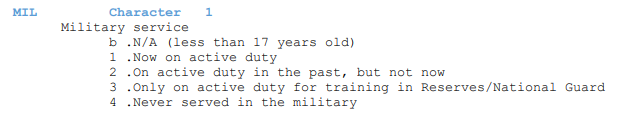

In [ ]:
# Removing GQ military from synthetic persons
from IPython import display
synthetic_persons_noGQ = synthetic_persons[synthetic_persons['MIL'] != 1.0] # Removing Acive Duty people 
display.Image("./puma_mil_info.png")

In [ ]:
# Removing GQ data from Synthetic Households info
# Nivedya saud 'GQ_type [1,2,3] is [Military, College, Other]'
synthetic_households_No_GQ = synthetic_households[synthetic_households['GQ_type'] != 1]

In [ ]:
# Synthetic households (SP) -- without GQ
sh_mgra_noGQ = pd.DataFrame(synthetic_households_No_GQ['mgra'].value_counts()).rename(columns={'mgra':'Total'})
sh_mgra_noGQ.index.name = 'mgra'

sh_tract_noGQ = pd.DataFrame(synthetic_households_No_GQ['tract'].value_counts()).rename(columns={'tract':'Total'})
sh_tract_noGQ.index.name = 'tract'

sh_CPA_noGQ = pd.DataFrame(synthetic_households_No_GQ['CPA'].value_counts()).rename(columns={'CPA':'Total'})
sh_CPA_noGQ.index.name = 'CPA'

sh_jurisdiction_noGQ = pd.DataFrame(synthetic_households_No_GQ['Jurisdiction'].value_counts()).rename(columns={'Jurisdiction':'Total'})
sh_jurisdiction_noGQ.index.name = 'Jurisdiction'

sh_LUZ_noGQ = pd.DataFrame(synthetic_households_No_GQ['LUZ'].value_counts()).rename(columns={'LUZ':'Total'})
sh_LUZ_noGQ.index.name = 'LUZ'

sh_Region_noGQ = pd.DataFrame(synthetic_households_No_GQ['Region'].value_counts()).rename(columns={'Region':'Total'})
sh_Region_noGQ.index.name = 'Region'

In [ ]:
# Synthetic Persons (SP) -- without GQ
sp_mgra_noGQ = pd.DataFrame(synthetic_persons_noGQ['mgra'].value_counts()).rename(columns={'mgra':'Total'})
sp_mgra_noGQ.index.name = 'mgra'

sp_tract_noGQ = pd.DataFrame(synthetic_persons_noGQ['tract'].value_counts()).rename(columns={'tract':'Total'})
sp_tract_noGQ.index.name = 'tract'

sp_CPA_noGQ = pd.DataFrame(synthetic_persons_noGQ['CPA'].value_counts()).rename(columns={'CPA':'Total'})
sp_CPA_noGQ.index.name = 'CPA'

sp_jurisdiction_noGQ = pd.DataFrame(synthetic_persons_noGQ['Jurisdiction'].value_counts()).rename(columns={'Jurisdiction':'Total'})
sp_jurisdiction_noGQ.index.name = 'Jurisdiction'

sp_LUZ_noGQ = pd.DataFrame(synthetic_persons_noGQ['LUZ'].value_counts()).rename(columns={'LUZ':'Total'})
sp_LUZ_noGQ.index.name = 'LUZ'

sp_Region_noGQ = pd.DataFrame(synthetic_persons_noGQ['Region'].value_counts()).rename(columns={'Region':'Total'})
sp_Region_noGQ.index.name = 'Region'

# Comparison with Forecast Data
- Will be checking with the 2019 forecast values (These are ran on MGRA series 15)
- Comparing population difference between the two. 

In [ ]:
forecast_data_mgra = pd.read_csv('J:/DataScience/DataQuality/QAQC/forecast_automation/mgra_series_15_2019_CSV_outputs/mgra_2019_CSV_Data_ind_QA.csv')
forecast_data_jurisdiction = pd.read_csv('J:/DataScience/DataQuality/QAQC/forecast_automation/mgra_series_15_2019_CSV_outputs/jurisdiction_2019_CSV_Data_ind_QA.csv')
forecast_data_region = pd.read_csv('J:/DataScience/DataQuality/QAQC/forecast_automation/mgra_series_15_2019_CSV_outputs/region_2019_CSV_Data_ind_QA.csv')

## Population Comparison

### Without GQ Removal

#### MGRA Level Check

In [ ]:
mgra_population = forecast_data_mgra[['mgra','pop']]
mgra_persons_comparison = sp_mgra.reset_index().merge(mgra_population, how='left', on='mgra')
mgra_persons_comparison.columns = ['mgra', 'popsim_pop', 'forecast_pop']
mgra_persons_comparison['Diff'] = mgra_persons_comparison['popsim_pop'] - mgra_persons_comparison['forecast_pop']
mgra_persons_comparison = mgra_persons_comparison.sort_values('Diff', ascending=False)
mgra_persons_comparison = mgra_persons_comparison.reset_index(drop=True)
mgra_persons_comparison

,mgra,popsim_pop,forecast_pop,Diff
0,4929,8528,4264,4264
1,7507,4228,3623,605
2,19747,3194,2742,452
3,5878,11396,11018,378
4,2428,3395,3028,367
...,...,...,...,...
18897,19499,1465,1610,-145
18898,2768,673,821,-148
18899,6963,1952,2105,-153
18900,13437,1852,2013,-161


#### Jurisdiction Level Check

In [ ]:
jurisdiction_population = forecast_data_jurisdiction[['Jurisdiction','pop']]
jurisdiction_persons_comparison = sp_jurisdiction.reset_index().merge(jurisdiction_population, how='left', on='Jurisdiction')
jurisdiction_persons_comparison.columns = ['Jurisdiction', 'popsim_pop', 'forecast_pop']
jurisdiction_persons_comparison['Diff'] = jurisdiction_persons_comparison['popsim_pop'] - jurisdiction_persons_comparison['forecast_pop']
jurisdiction_persons_comparison['pct_diff'] = round((jurisdiction_persons_comparison['forecast_pop'] - jurisdiction_persons_comparison['popsim_pop'])/jurisdiction_persons_comparison['forecast_pop'] * 100, 3)
jurisdiction_persons_comparison = jurisdiction_persons_comparison.sort_values('pct_diff', ascending=False)
jurisdiction_persons_comparison = jurisdiction_persons_comparison.reset_index(drop=True)
jurisdiction_persons_comparison

,Jurisdiction,popsim_pop,forecast_pop,Diff,pct_diff
0,Coronado,22538,23813,-1275,5.354
1,National City,60298,62256,-1958,3.145
2,Encinitas,61329,62098,-769,1.238
3,Oceanside,176974,177245,-271,0.153
4,Escondido,152197,152359,-162,0.106
5,Carlsbad,113561,113623,-62,0.055
6,Vista,102443,102041,402,-0.394
7,Unincorporated,509309,507278,2031,-0.400
8,San Diego,1440291,1432100,8191,-0.572
9,San Marcos,97264,96610,654,-0.677


#### Region Level Check

In [ ]:
region_population = forecast_data_region[['Region','pop']]
region_persons_comparison = sp_Region.reset_index().merge(region_population, how='left', on='Region')
region_persons_comparison.columns = ['Jurisdiction', 'popsim_pop', 'forecast_pop']
region_persons_comparison['Diff'] = region_persons_comparison['popsim_pop'] - region_persons_comparison['forecast_pop']
region_persons_comparison['pct_diff'] = round((region_persons_comparison['forecast_pop'] - region_persons_comparison['popsim_pop'])/region_persons_comparison['forecast_pop'] * 100, 3)
region_persons_comparison = region_persons_comparison.sort_values('pct_diff', ascending=False)
region_persons_comparison = region_persons_comparison.reset_index(drop=True)
region_persons_comparison

,Jurisdiction,popsim_pop,forecast_pop,Diff,pct_diff
0,San Diego,3361280,3343626,17654,-0.528


## Household Number Comparison

### Without GQ Removal

#### MGRA Level Check

In [ ]:
mgra_households = forecast_data_mgra[['mgra','hh']]
mgra_households_comparison = sh_mgra.reset_index().merge(mgra_households, how='left', on='mgra')
mgra_households_comparison.columns = ['mgra', 'popsim_hh', 'forecast_hh']
mgra_households_comparison['Diff'] = mgra_households_comparison['popsim_hh'] - mgra_households_comparison['forecast_hh']
mgra_households_comparison = mgra_households_comparison.sort_values('Diff', ascending=False)
mgra_households_comparison = mgra_households_comparison.reset_index(drop=True)
mgra_households_comparison

,mgra,popsim_hh,forecast_hh,Diff
0,8979,9763,0,9763
1,4929,8528,0,8528
2,5972,5197,0,5197
3,9161,5011,0,5011
4,12713,4776,0,4776
...,...,...,...,...
18897,17539,200,204,-4
18898,7201,38,42,-4
18899,19473,77,81,-4
18900,19531,93,98,-5


#### Jurisdiction Level Check

In [ ]:
jurisdiction_population = forecast_data_jurisdiction[['Jurisdiction','hh']]
jurisdiction_households_comparison = sh_jurisdiction.reset_index().merge(jurisdiction_population, how='left', on='Jurisdiction')
jurisdiction_households_comparison.columns = ['Jurisdiction', 'popsim_hh', 'forecast_hh']
jurisdiction_households_comparison['Diff'] = jurisdiction_households_comparison['popsim_hh'] - jurisdiction_households_comparison['forecast_hh']
jurisdiction_households_comparison['pct_diff'] = round((jurisdiction_households_comparison['forecast_hh'] - jurisdiction_households_comparison['popsim_hh'])/jurisdiction_households_comparison['forecast_hh'] * 100, 3)
jurisdiction_households_comparison = jurisdiction_households_comparison.sort_values('pct_diff', ascending=False)
jurisdiction_households_comparison = jurisdiction_households_comparison.reset_index(drop=True)
jurisdiction_households_comparison

,Jurisdiction,popsim_hh,forecast_hh,Diff,pct_diff
0,Del Mar,2083,2083,0,0.000
1,Solana Beach,5923,5923,0,0.000
2,Oceanside,62714,61779,935,-1.513
3,Chula Vista,84200,82551,1649,-1.998
4,Carlsbad,44748,43833,915,-2.087
5,Encinitas,25208,24680,528,-2.139
6,La Mesa,25797,25138,659,-2.622
7,Poway,16828,16276,552,-3.391
8,Lemon Grove,8910,8564,346,-4.040
9,Imperial Beach,10021,9577,444,-4.636


#### Region Level Check 

In [ ]:
region_population = forecast_data_region[['Region','hh']]
region_households_comparison = sh_Region.reset_index().merge(region_population, how='left', on='Region')
region_households_comparison.columns = ['Jurisdiction', 'popsim_hh', 'forecast_hh']
region_households_comparison['Diff'] = region_households_comparison['popsim_hh'] - region_households_comparison['forecast_hh']
region_households_comparison['pct_diff'] = round((region_households_comparison['forecast_hh'] - region_households_comparison['popsim_hh'])/region_households_comparison['forecast_hh'] * 100, 3)
region_households_comparison = region_households_comparison.sort_values('pct_diff', ascending=False)
region_households_comparison = region_households_comparison.reset_index(drop=True)
region_households_comparison

,Jurisdiction,popsim_hh,forecast_hh,Diff,pct_diff
0,San Diego,1267147,1153032,114115,-9.897
